## **Elaborazione di Immagini Mediche**
### Contest 2021/22 - Segmentazione ghiandola prostatica in immagini MRI




*   Collegamento a Google Drive e import delle librerie necessarie



In [ ]:
# Before running the script, reset the runtime to factory reset (Runtime -> Factory Reset Runtime)
# and then change runtime type to GPU (Runtime -> Change runtime type)

# Install libriary dependencies for running deep learning
!pip install tensorflow==2.1.0
!pip install keras==2.3.1
!pip install segmentation_models==1.0.1
!pip install h5py==2.10.0 
!pip install plotly==5.3.1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import random
import numpy as np
import plotly.express as px
import plotly.express as px

from matplotlib import pyplot as plt
from tqdm import tqdm
from skimage.io import imread, imshow, imsave
from skimage.transform import resize
from skimage.segmentation import mark_boundaries

import keras
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

from segmentation_models import Unet

Mounted at /content/drive


Using TensorFlow backend.


Segmentation Models: using `keras` framework.


*   Preparazione del dataset

In [ ]:
# Tip : eliminare una cartella non vuota all'interno di Colab
#!rm -rf <path_to_folder_name>  # inserire path della cartella da rimuovere

# Tip: per scaricare una o più cartelle da Colab occorre prima comprimerle in un
# unico archivio RAR
#!zip -r <file_zip> <path_to_folder_name>

In [ ]:
# Caricamento dataset in formato .rar da Google Drive a Colab
!pip install unrar
!unrar x "drive/MyDrive/EIM/Contest/DATASET_stu.rar"   # inserire path completa in cui si trovano i dati (es. "drive/MyDrive/..../DATASET_stu.rar")


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from drive/MyDrive/EIM/Contest/DATASET_stu.rar

Creating    DATASET_stu                                               OK
Creating    DATASET_stu/test                                          OK
Creating    DATASET_stu/test/images                                   OK
Extracting  DATASET_stu/test/images/2001.tiff                              1%  2%  OK 
Extracting  DATASET_stu/test/images/2022.tiff                              4%  OK 
Extracting  DATASET_stu/test/images/3032.tiff                              6%  OK 
Extracting  DATASET_stu/test/images/3068.tiff                              7%  8%  OK 
Extracting  DATASET_stu/test/images/3268.tiff                              9%  OK 
Extracting  DATASET_stu/test/images/MIP-PROSTATE-01-0002.tiff             11%  OK 
Extracting  DATASET_stu/test/images/MIP-PROSTATE-01-0008.tiff             13%

In [ ]:
# Creare la cartella che conterrà i risultati della rete nel test set
path_results = os.path.join("DATASET_stu","test","automatic")
os.mkdir(path_results)
path_results = os.path.join("DATASET_stu","train","automatic")
os.mkdir(path_results)
path_results = os.path.join("DATASET_stu","val","automatic")
os.mkdir(path_results)

In [ ]:
current_dir = '/content/'
dataset_name = 'DATASET_stu'

# Path
TRAIN_IMG_path = os.path.join(dataset_name,'train','images')
TRAIN_MASK_path = os.path.join(dataset_name,'train','manual')
VAL_IMG_path = os.path.join(dataset_name,'val','images')
VAL_MASK_path = os.path.join(dataset_name,'val','manual')

# Estrazione della lista di volumi del training e validation set
train_images = os.listdir(TRAIN_IMG_path)
val_images = os.listdir(VAL_IMG_path)

# Si vuole allenare una rete che prenda in ingresso un'immagine 512x512x3 (rgb) 
# e la rispettiva maschera di segmentazione (0:background, 255:lesione)
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
NUM_CLASSES = 2

In [ ]:
from skimage.color import gray2rgb

# Inizializzazioni matrici per il Training Set che conteranno le singole slice e le rispettive maschere.
X_train = np.zeros((len(train_images)*24,IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_images)*24,IMG_WIDTH,IMG_HEIGHT,NUM_CLASSES), dtype=np.float32)


 
for n, id_ in tqdm(enumerate(train_images), total=len(train_images)):

    # la variabile "n" rappresenta un contatore (0-num_immagini) mentre "id_" 
    # contiene il nome della n-esima immagine
    
    # Lettura immagine 
    img = imread(TRAIN_IMG_path+ "/" + id_ )
    for l in range(np.size(img,0)):

      #conversione dell'immagine in formato RGB e ricampionamento a 512x512
      img2 = gray2rgb(img[l,:,:])
      img2 = resize(img2,(512,512),preserve_range=True)

      #zooming dell'immagine
      X_train[(n*24)+l] = img2[128:384,128:384] 
    
    # Lettura maschera BW e ricampionamento maschera a 512x512
    mask = imread(TRAIN_MASK_path+ "/" +id_)
    for t in range(np.size(mask,0)):
      mask2 =  mask[t,:,:]
      mask2 = resize(mask2,(512,512),preserve_range=True)
      mask2 = to_categorical(mask2, num_classes=NUM_CLASSES, dtype='float32')

      #zooming della maschera
      Y_train[(n*24)+t] = mask2[128:384,128:384]


# Creazione matrici per validation set che conteranno le singole slice e le rispettive maschere.
X_val = np.zeros((len(val_images)*24,IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS), dtype=np.uint8)
Y_val = np.zeros((len(val_images)*24,IMG_WIDTH,IMG_HEIGHT,NUM_CLASSES), dtype=np.float32)

for n, id_ in tqdm(enumerate(val_images), total=len(val_images)):
    # la variabile "n" rappresenta un contatore (0-num_immagini) mentre "id_" 
    # contiene il nome della n-esima immagine
    
    # Lettura immagine 
    img = imread(VAL_IMG_path+"/"+id_)
    for l in range(np.size(img,0)):

      #conversione dell'immagine in formato RGB e ricampionamento a 512x512
      img2 = gray2rgb(img[l,:,:]) 
      img2 = resize(img2,(512,512),preserve_range=True)

      #zooming dell'immagine
      X_val[(n*24)+l] = img2[128:384,128:384]

    # Lettura maschera BW e ricampionamento maschera a 512x512
    mask = imread(VAL_MASK_path+ "/" +id_)
    for t in range(np.size(mask,0)):
      mask2 =  mask[t,:,:]
      mask2 = resize(mask2,(512,512),preserve_range=True)
      mask2 = to_categorical(mask2, num_classes=NUM_CLASSES, dtype='float32')

      #zooming della maschera
      Y_val[(n*24)+t] = mask2[128:384,128:384]


In [ ]:
#Caricamento del modello salvato
model = load_model('drive/MyDrive/EIM/Contest/Script/modelloCONTEST')

In [ ]:
#Segmentazioni automatiche per il Training Set

#Matrice che conterrà i risultati della segmentazione automatica.
Y_train2 = np.zeros((len(train_images)*24,IMG_WIDTH,IMG_HEIGHT), dtype=np.float32)


 # Apply CNN for prediction

for l in tqdm(range(len(X_train))):
  img=X_train[l]
  img1 = np.reshape(img,(1,256,256,3))
  
  softmax = model.predict(img1)
  softmax = np.reshape(softmax,(256,256,2))
  softmax = resize(softmax, (256, 256), mode='constant', preserve_range=True)
  
  mask_auto = softmax[:,:,1]
  mask_auto[mask_auto<0.5]=0
  mask_auto[mask_auto>0.5]=1
  mask_auto = mask_auto.astype(np.uint8)

  Y_train2[l]=mask_auto

  






100%|██████████| 768/768 [00:36<00:00, 21.14it/s]


In [ ]:
# Ripulire maschere con pochi pixel bianchi per Training Set
for s in tqdm(range(len(Y_train2))):
  somma_slice = np.sum(Y_train2[s])
  if somma_slice<500:
    Y_train2[s]= np.zeros((256,256),dtype=np.uint8)

100%|██████████| 768/768 [00:00<00:00, 13001.39it/s]


In [ ]:
#Libreria necessaria per post-processing

!pip install opencv-python 
import cv2

In [ ]:
# Eliminazione dei buchi nelle maschere automatiche del Training Set
from skimage.morphology import reconstruction

kernel = np.ones((5,5),dtype=np.uint8)
kernel2 = np.ones((5,5),dtype=np.uint8)

for b in tqdm(range(len(Y_train2))):
  opening = cv2.morphologyEx(Y_train2[b], cv2.MORPH_OPEN, kernel)
  closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel2)
  Y_train2[b] = closing

  


100%|██████████| 768/768 [00:00<00:00, 2454.54it/s]


In [ ]:
#Segmentazioni automatiche per il Validation Set

#Matrice che conterrà i risultati della segmentazione automatica.
Y_val2 = np.zeros((len(val_images)*24,IMG_WIDTH,IMG_HEIGHT), dtype=np.float32)


 # Apply CNN for prediction

for l in tqdm(range(len(X_val))):
  img=X_val[l]
  img1 = np.reshape(img,(1,256,256,3))
  
  softmax = model.predict(img1)
  softmax = np.reshape(softmax,(256,256,2))
  softmax = resize(softmax, (256, 256), mode='constant', preserve_range=True)
  
  mask_auto = softmax[:,:,1]
  mask_auto[mask_auto<0.5]=0
  mask_auto[mask_auto>0.5]=1
  mask_auto = mask_auto.astype(np.uint8)

  Y_val2[l]=mask_auto

100%|██████████| 192/192 [00:08<00:00, 22.03it/s]


In [ ]:
# Ripulire maschere con pochi pixel bianchi per Validation Set
for s in tqdm(range(len(Y_val2))):
  somma_slice = np.sum(Y_val2[s])
  if somma_slice<500:
    Y_val2[s]= np.zeros((256,256),dtype=np.uint8)



100%|██████████| 192/192 [00:00<00:00, 8200.51it/s]


In [ ]:
# Eliminazione dei buchi per Validation Set

kernel = np.ones((5,5),dtype=np.uint8)
kernel2 = np.ones((5,5),dtype=np.uint8)

for b in tqdm(range(len(Y_val2))):
  opening = cv2.morphologyEx(Y_val2[b], cv2.MORPH_OPEN, kernel)
  closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel2)
  Y_val2[b] = closing

100%|██████████| 192/192 [00:00<00:00, 2328.34it/s]


189


(<matplotlib.image.AxesImage at 0x7f88c7d4f710>, Text(0.5, 1.0, 'automatic'))

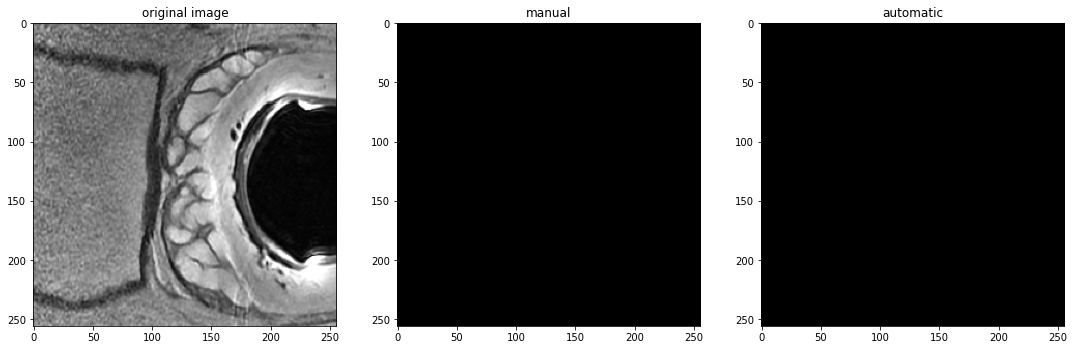

In [ ]:
#Visualizzazione immagini del Training Set

random_index = random.randrange(0,768,1)
print(random_index)

fig = plt.figure(figsize=(25,25))
ax1 = fig.add_subplot(141)
ax1.imshow(X_train[random_index]), ax1.set_title('original image')
ax2 = fig.add_subplot(142)
mask_plot = np.squeeze(Y_train[random_index])
ax2.imshow(mask_plot[:,:,1],cmap=plt.cm.gray), ax2.set_title('manual')    
ax3 = fig.add_subplot(143)
ax3.imshow(Y_train2[random_index],cmap=plt.cm.gray), ax3.set_title('automatic')
  

77


(<matplotlib.image.AxesImage at 0x7f88c67c0f10>, Text(0.5, 1.0, 'automatic'))

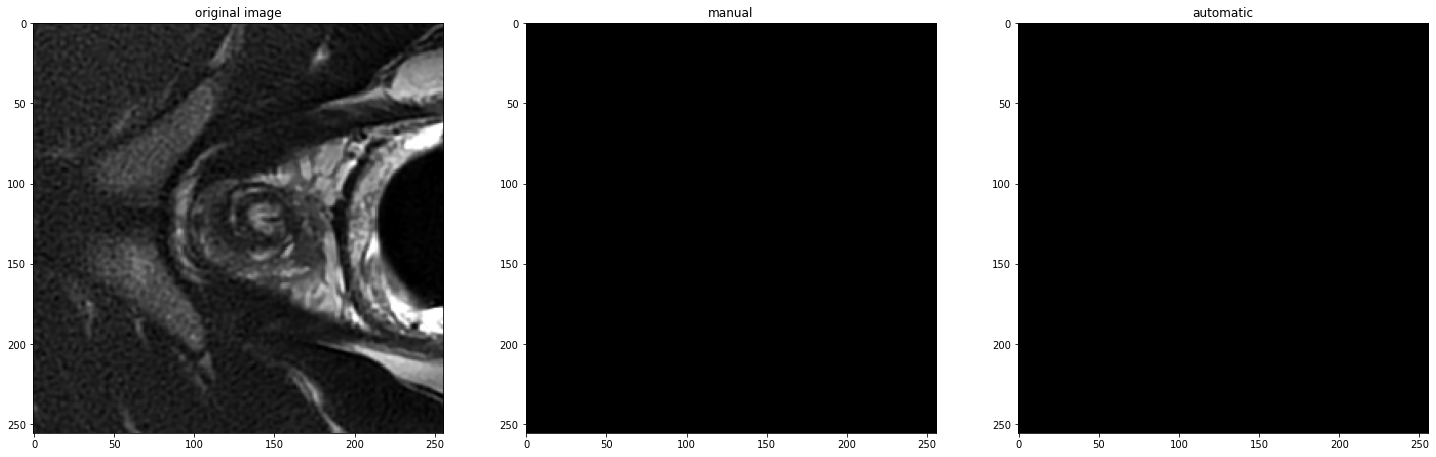

In [ ]:
#Visualizzazione immagini del Validation Set

random_index = random.randrange(0,192,1)
random_index = 77
print(random_index)

fig = plt.figure(figsize=(25,25))
ax1 = fig.add_subplot(131)
ax1.imshow(X_val[random_index]), ax1.set_title('original image')
ax2 = fig.add_subplot(132)
mask_plot = np.squeeze(Y_val[random_index])
ax2.imshow(mask_plot[:,:,1],cmap=plt.cm.gray), ax2.set_title('manual')    
ax3 = fig.add_subplot(133)
ax3.imshow(Y_val2[random_index],cmap=plt.cm.gray), ax3.set_title('automatic')

In [ ]:
#Salvatggio segmentazioni automatiche per il Training Set
TRAIN_AUT_path = os.path.join(dataset_name, "train",'automatic')

l=0
n=0
matrice=np.zeros((24,512,512), dtype=np.float32)
img=np.zeros((512,512),dtype=np.uint8)

for b in tqdm(range(len(Y_train2))):
  img[128:384,128:384]=Y_train2[b]
  matrice[l,:,:]=img
  l=l+1
  
  if (b+1)%24 == 0: #Salvataggio dei Volumi
    l=0
    imsave(TRAIN_AUT_path+'/'+train_images[n], matrice)
    n=n+1
    matrice=np.zeros((24,512,512), dtype=np.float32)
    
  img=np.zeros((512,512),dtype=np.uint8)





    




  6%|▋         | 48/768 [00:00<00:02, 271.02it/s]

(24, 512, 512)
(24, 512, 512)
(24, 512, 512)


 17%|█▋        | 134/768 [00:00<00:02, 311.22it/s]

(24, 512, 512)
(24, 512, 512)
(24, 512, 512)


 22%|██▏       | 168/768 [00:00<00:02, 259.25it/s]

(24, 512, 512)
(24, 512, 512)
(24, 512, 512)


 34%|███▍      | 264/768 [00:00<00:01, 261.70it/s]

(24, 512, 512)
(24, 512, 512)
(24, 512, 512)


 41%|████      | 312/768 [00:01<00:01, 259.60it/s]

(24, 512, 512)
(24, 512, 512)
(24, 512, 512)


 53%|█████▎    | 408/768 [00:01<00:01, 267.56it/s]

(24, 512, 512)
(24, 512, 512)
(24, 512, 512)


 64%|██████▍   | 493/768 [00:01<00:01, 269.45it/s]

(24, 512, 512)
(24, 512, 512)


 69%|██████▊   | 527/768 [00:01<00:00, 287.25it/s]

(24, 512, 512)
(24, 512, 512)
(24, 512, 512)


 76%|███████▌  | 583/768 [00:02<00:00, 239.87it/s]

(24, 512, 512)
(24, 512, 512)
(24, 512, 512)


 88%|████████▊ | 672/768 [00:02<00:00, 246.89it/s]

(24, 512, 512)
(24, 512, 512)
(24, 512, 512)


 97%|█████████▋| 744/768 [00:02<00:00, 256.02it/s]

(24, 512, 512)
(24, 512, 512)
(24, 512, 512)


100%|██████████| 768/768 [00:02<00:00, 259.13it/s]


In [ ]:
#Salvatggio segmentazioni automatiche per il Validation Set
VAL_AUT_path = os.path.join(dataset_name, "val",'automatic')

l=0
n=0
matrice=np.zeros((24,512,512), dtype=np.float32)
img=np.zeros((512,512),dtype=np.uint8)

for b in tqdm(range(len(Y_val2))):
  img[128:384,128:384]=Y_val2[b]
  matrice[l,:,:]=img
  l=l+1

  if (b+1)%24 == 0: #Salvataggio dei Volumi
    l=0
    imsave(VAL_AUT_path+'/'+val_images[n], matrice)
    n=n+1

  img=np.zeros((512,512),dtype=np.uint8)


  0%|          | 0/192 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning:

DATASET_stu/val/automatic/MIP-PROSTATE-01-0017.tiff is a low contrast image

100%|██████████| 192/192 [00:00<00:00, 277.76it/s]


In [ ]:
# Inizializzazione matrice per il Test Set che conterà le singole slice.

# Path per le immagini del Test Set
TEST_IMG_path = os.path.join(dataset_name,'test','images')

# Estrazione della lista di volumi del Test Set.
test_images = os.listdir(TEST_IMG_path)

X_test = np.zeros((len(test_images)*24,IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS), dtype=np.uint8)

for n, id_ in tqdm(enumerate(test_images), total=len(test_images)):

    # la variabile "n" rappresenta un contatore (0-num_immagini) mentre "id_" 
    # contiene il nome della n-esima immagine
    
    # Lettura immagine 
    img = imread(TEST_IMG_path+ "/" + id_ )
    for l in range(np.size(img,0)):

      #conversione dell'immagine in formato RGB e ricampionamento a 512x512
      img2 = gray2rgb(img[l,:,:])
      img2 = resize(img2,(512,512),preserve_range=True)

      #zooming dell'immagine 
      X_test[(n*24)+l] = img2[128:384,128:384]


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


In [ ]:
#Segmentazioni automatiche per il Test Set

#Matrice che conterrà i risultati della segmentazione automatica.
Y_test2 = np.zeros((len(test_images)*24,IMG_WIDTH,IMG_HEIGHT), dtype=np.float32)

 # Apply CNN for prediction

for l in tqdm(range(len(X_test))):
  img=X_test[l]
  img1 = np.reshape(img,(1,256,256,3))
  
  softmax = model.predict(img1)
  softmax = np.reshape(softmax,(256,256,2))
  softmax = resize(softmax, (256, 256), mode='constant', preserve_range=True)
  
  mask_auto = softmax[:,:,1]
  mask_auto[mask_auto<0.5]=0
  mask_auto[mask_auto>0.5]=1
  mask_auto = mask_auto.astype(np.uint8)

  Y_test2[l]=mask_auto

100%|██████████| 240/240 [00:10<00:00, 21.90it/s]


In [ ]:
# Ripulire immagini con pochi pixel bianchi per il Test Set

for s in tqdm(range(len(Y_test2))):
  somma_slice = np.sum(Y_test2[s])
  if somma_slice<500:
    Y_test2[s]= np.zeros((256,256),dtype=np.uint8)

100%|██████████| 240/240 [00:00<00:00, 9302.33it/s]


In [ ]:
# Eliminazione dei buchi per Test Set
kernel = np.ones((5,5),dtype=np.uint8)
kernel2 = np.ones((5,5),dtype=np.uint8)

for b in tqdm(range(len(Y_test2))):
  opening = cv2.morphologyEx(Y_test2[b], cv2.MORPH_OPEN, kernel)
  closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel2)
  Y_test2[b] = closing

100%|██████████| 240/240 [00:00<00:00, 2470.74it/s]


167


(<matplotlib.image.AxesImage at 0x7f88c5919410>, Text(0.5, 1.0, 'automatic'))

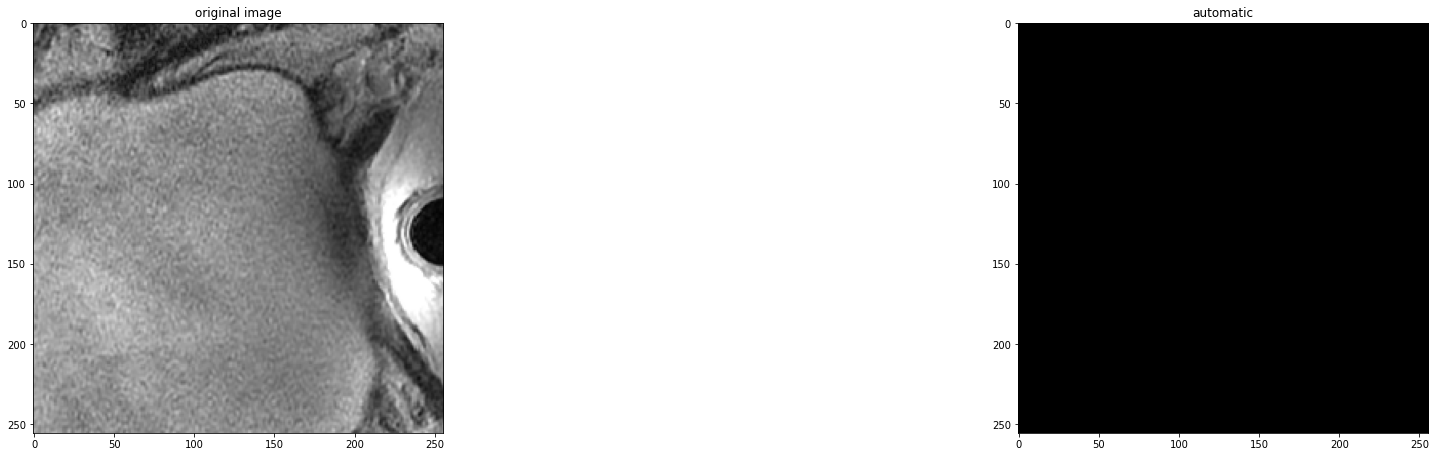

In [ ]:
#Visualizzazione immagini del Test Set

random_index = random.randrange(0,240,1)
print(random_index)

fig = plt.figure(figsize=(25,25))
ax1 = fig.add_subplot(131)
ax1.imshow(X_test[random_index]), ax1.set_title('original image')   
ax2 = fig.add_subplot(133)
ax2.imshow(Y_test2[random_index],cmap=plt.cm.gray), ax2.set_title('automatic')

In [ ]:
#Salvatggio segmentazioni automatiche per il Test Set
TEST_AUT_path = os.path.join(dataset_name, "test",'automatic')

l=0
n=0
matrice=np.zeros((24,512,512), dtype=np.float32)
img=np.zeros((512,512),dtype=np.uint8)

for b in tqdm(range(len(Y_test2))):
  img[128:384,128:384]=Y_test2[b]
  matrice[l,:,:]=img
  l=l+1

  if (b+1)%24 == 0: #Salvataggio dei Volumi
    l=0
    imsave(TEST_AUT_path+'/'+test_images[n], matrice)
    n=n+1
    matrice=np.zeros((24,512,512), dtype=np.float32)
    
  img=np.zeros((512,512),dtype=np.uint8)
  



100%|██████████| 240/240 [00:00<00:00, 245.57it/s]


In [ ]:
#Evaluation Criteria per slice

def single_dice_coef(y_true,y_pred_bin):

  intersection=np.sum(np.multiply(y_true,y_pred_bin))

  if(np.sum(y_true)==0) and (np.sum(y_pred_bin)==0):
    return 1

  return (2*intersection) / (np.sum(y_true) + np.sum(y_pred_bin))

In [ ]:
#Valutazione maschere del Training Set per slice

l=0
n=0
matrice2=np.zeros((len(X_train),1), dtype=np.float32)

for b in tqdm(range(len(Y_train2))):
  img=Y_train2[b]
  buccia = Y_train[b,:,:,1]
  risultato = single_dice_coef(buccia,img)
  matrice2[l]=risultato
  #print(matrice2[l])
  l=l+1

print(matrice2.shape)
print(matrice2.mean())

#for s in tqdm(range(24)):
 # print(matrice2[s])




100%|██████████| 768/768 [00:00<00:00, 3272.21it/s]

(768, 1)
0.9809651


In [ ]:
#Valutazione maschere del Validation Set per slice

l=0
n=0
matrice2=np.zeros((len(X_val),1), dtype=np.float32)

for b in tqdm(range(len(Y_val2))):
  img=Y_train2[b]
  buccia = Y_train[b,:,:,1]
  risultato = single_dice_coef(buccia,img)
  matrice2[l]=risultato
  #print(matrice2[l])
  l=l+1

print(matrice2.shape)
print(matrice2.mean())


100%|██████████| 192/192 [00:00<00:00, 3206.09it/s]

(192, 1)
0.98094076


In [ ]:
# Path per la valutazione dei volumi di Training e Validation Set
TRAIN_AUT_path = os.path.join(dataset_name,'train','automatic')
TRAIN_MASK_path = os.path.join(dataset_name,'train','manual')
VAL_AUT_path = os.path.join(dataset_name,'val','automatic')
VAL_MASK_path = os.path.join(dataset_name,'val','manual')

# Estrazione della lista di volumi del Training e del Validation Set
train_aut = os.listdir(TRAIN_AUT_path)
val_aut = os.listdir(VAL_AUT_path)

In [ ]:
# Inizializzazioni matrici che conterranno i volumi delle maschere del Training Set 
automatic_train = np.zeros((len(train_aut),24,512,512), dtype=np.uint8)
manuale_train = np.zeros((len(train_images),24,512,512), dtype=np.float32)


 
for n, id_ in tqdm(enumerate(train_images), total=len(train_images)):
  
    # Lettura volume
    vol = imread(TRAIN_AUT_path+ "/" + id_ )
    automatic_train[n]=vol
    
    # Lettura maschere BW 
    mask = imread(TRAIN_MASK_path+ "/" +id_)
    manuale_train[n]=mask

100%|██████████| 32/32 [00:00<00:00, 40.91it/s]


In [ ]:
#Evaluation Criteria per volume

def dice_coef(volume_true,volume_pred):
  intersection = np.sum(volume_pred[volume_true==1])*2
  dice = intersection / (np.sum(volume_true)+np.sum(volume_true))
  return dice


In [ ]:
# Valutazione dice per volumi del Training Set
dice2=np.zeros((32,1),dtype=np.float32)

for g in tqdm(range(32)):
  dice2[g] = dice_coef(manuale_train[g],automatic_train[g])

somma=np.sum(dice2)/32

print('\n')
print(somma)

100%|██████████| 32/32 [00:00<00:00, 83.86it/s]



0.9619165658950806


In [ ]:
# Inizializzazioni matrici che conterranno i volumi delle maschere del Validation Set
automatic_val = np.zeros((len(val_aut),24,512,512), dtype=np.uint8)
manuale_val = np.zeros((len(val_aut),24,512,512), dtype=np.float32)


 
for n, id_ in tqdm(enumerate(val_aut), total=len(val_aut)):
  
    # Lettura volume 
    vol = imread(VAL_AUT_path+ "/" + id_ )
    automatic_val[n]=vol
    
    # Lettura maschere BW 
    mask = imread(VAL_MASK_path+ "/" +id_)
    manuale_val[n]=mask

100%|██████████| 8/8 [00:00<00:00, 45.82it/s]


In [ ]:
# Valutazione dice per i volumi del Validation Set
dice2=np.zeros((8,1),dtype=np.float32)

for g in tqdm(range(8)):
  dice2[g] = dice_coef(manuale_val[g],automatic_val[g])

somma=np.sum(dice2)/8

print('\n')
print(somma)

100%|██████████| 8/8 [00:00<00:00, 85.02it/s]



0.8997993469238281
